## PREPROCESSING
### Get the dataset
Load the dataset, split it in two for trainin and validation. As in the Reference model provided by [Lyft](https://level5.lyft.com/), a dataframe with one scene per row is created.

In [1]:
DATASET_VERSION = 'v1.02-train'
DATASET_ROOT = '../../nuscenes-devkit/data/'

#The code will generate data, visualization and model checkpoints
ARTIFACTS_FOLDER = "./artifacts"

In [2]:
%load_ext autoreload

from datetime import datetime
from functools import partial
import glob
#Disabled for numpy and opencv: avod has opencv and numpy versions for several methods
from multiprocessing import Pool

import os
#os.environ["OMP_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import cv2
from PIL import Image
import numpy as np
from tqdm import tqdm, tqdm_notebook
import argparse
import tensorflow as tf
import scipy
import scipy.ndimage
import scipy.special
from scipy.spatial.transform import Rotation as R

from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud, Box, Quaternion
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix

In [3]:
level5data = LyftDataset(json_path=DATASET_ROOT + "/v1.02-train", data_path=DATASET_ROOT, verbose=True)
os.makedirs(ARTIFACTS_FOLDER, exist_ok=True)

9 category,
18 attribute,
4 visibility,
15991 instance,
8 sensor,
128 calibrated_sensor,
149072 ego_pose,
148 log,
148 scene,
18634 sample,
149072 sample_data,
539765 sample_annotation,
1 map,
Done loading in 11.1 seconds.
Reverse indexing ...
Done reverse indexing in 3.5 seconds.


In [4]:
#Panda's dataframe with one scene per row. Useful for selecting the sensors later
records = [(level5data.get('sample', record['first_sample_token'])['timestamp'], record) for record in
        level5data.scene]

entries = []

for start_time, record in sorted(records):
    start_time = level5data.get('sample', record['first_sample_token'])['timestamp'] / 1000000

    token = record['token']
    name = record['name']
    date = datetime.utcfromtimestamp(start_time)
    host = "-".join(record['name'].split("-")[:2])
    first_sample_token = record["first_sample_token"]

    entries.append((host, name, date, token, first_sample_token))
            
df = pd.DataFrame(entries, columns=["host", "scene_name", "date", "scene_token", "first_sample_token"])

In [5]:
host_count_df = df.groupby("host")['scene_token'].count()
print(host_count_df)

host
host-a004    42
host-a005     1
host-a006     3
host-a007    26
host-a008     5
host-a009     9
host-a011    51
host-a012     2
host-a015     6
host-a017     3
Name: scene_token, dtype: int64


In [6]:
validation_hosts = ["host-a007", "host-a008", "host-a009"]

validation_df = df[df["host"].isin(validation_hosts)]
vi = validation_df.index
train_df = df[~df.index.isin(vi)]

First issue: avod in the O.G. version has only the car class and the pedestrian/bicycle class. It might be due to the fact that kitti had only those classes, but the issue lays in the fact that AVOD uses these .config files with some descriptions. I do not know where they come from, and if the data written comes from the authors or is a result file from the training. 

In [7]:
classes = ["car", "motorcycle", "bus", "bicycle", "truck", "pedestrian", "other_vehicle", "animal", "emergency_vehicle"]
classes_avod = ["car", "pedestrian", "bicycle"]

### Create the BEV for the LiDAR pointcloud data
AVOD processes the point clouds from the Velodyne in Bird's Eye View.

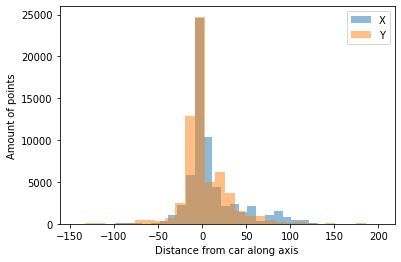

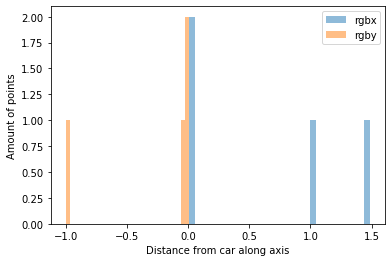

In [8]:
sample_token = train_df.first_sample_token.values[0]
sample = level5data.get("sample", sample_token)

sample_lidar_token = sample["data"]["LIDAR_TOP"]
sample_rgb_token = sample["data"]["CAM_FRONT"]
lidar_data = level5data.get("sample_data", sample_lidar_token)
rgb_data = level5data.get("sample_data", sample_rgb_token)
lidar_filepath = level5data.get_sample_data_path(sample_lidar_token)
img_filepath = level5data.get_sample_data_path(sample_rgb_token)

ego_pose = level5data.get("ego_pose", lidar_data["ego_pose_token"])
calibrated_sensor_lidar = level5data.get("calibrated_sensor", lidar_data["calibrated_sensor_token"])
calibrated_sensor_rgb = level5data.get("calibrated_sensor", rgb_data["calibrated_sensor_token"])

#Homogeneous transformation matrix from car frame to world frame.
global_from_car = transform_matrix(ego_pose['translation'],
                                   Quaternion(ego_pose['rotation']), inverse=False)

#Homogeneous transformation matrix from sensor coordinate frame to ego car frame.
car_from_sensor_lidar = transform_matrix(calibrated_sensor_lidar['translation'], Quaternion(calibrated_sensor_lidar['rotation']),
                                    inverse=False)
car_from_sensor_rgb = transform_matrix(calibrated_sensor_rgb['translation'], Quaternion(calibrated_sensor_rgb['rotation']),
                                    inverse=False)

lidar_pointcloud = LidarPointCloud.from_file(lidar_filepath)

#The lidar pointcloud is defined in the sensor's reference frame.
#It must be in the car's reference frame, so we transform each point
lidar_pointcloud.transform(car_from_sensor_lidar)

#A sanity check, the points should be centered around 0 in car space.
plt.hist(lidar_pointcloud.points[0], alpha=0.5, bins=30, label="X")
plt.hist(lidar_pointcloud.points[1], alpha=0.5, bins=30, label="Y")
plt.legend()
plt.xlabel("Distance from car along axis")
plt.ylabel("Amount of points")
plt.show()

plt.hist(car_from_sensor_rgb[0],alpha=0.5, bins=30, label="rgbx")
plt.hist(car_from_sensor_rgb[1],alpha=0.5, bins=30, label="rgby")
plt.legend()
plt.xlabel("Distance from car along axis")
plt.ylabel("Amount of points")
plt.show()

In [9]:
map_mask = level5data.map[0]["mask"]

def create_transformation_matrix_to_voxel_space(shape, voxel_size, offset):
    """
    Constructs a transformation matrix given an output voxel shape such that (0,0,0) ends up in the center.
    Voxel_size defines how large every voxel is in world coordinate, (1,1,1) would be the same as Minecraft voxels.
    
    An offset per axis in world coordinates (metric) can be provided, this is useful for Z (up-down) in lidar points.
    """
    
    shape, voxel_size, offset = np.array(shape), np.array(voxel_size), np.array(offset)
    
    tm = np.eye(4, dtype=np.float32)
    translation = shape/2 + offset/voxel_size
    
    tm = tm * np.array(np.hstack((1/voxel_size, [1])))

    tm[:3, 3] = np.transpose(translation)
    return tm

def transform_points(points, transf_matrix):
    """
    Transform (3,N) or (4,N) points using transformation matrix.
    """
    if points.shape[0] not in [3,4]:
        raise Exception("Points input should be (3,N) or (4,N) shape, received {}".format(points.shape))
    return transf_matrix.dot(np.vstack((points[:3, :], np.ones(points.shape[1]))))[:3, :]

def car_to_voxel_coords(points, shape, voxel_size, z_offset=0):
    if len(shape) != 3:
        raise Exception("Voxel volume shape should be 3 dimensions (x,y,z)")
        
    if len(points.shape) != 2 or points.shape[0] not in [3, 4]:
        raise Exception("Input points should be (3,N) or (4,N) in shape, found {}".format(points.shape))

    tm = create_transformation_matrix_to_voxel_space(shape, voxel_size, (0, 0, z_offset))
    p = transform_points(points, tm)
    return p

def create_voxel_pointcloud(points, shape, voxel_size=(0.5,0.5,1), z_offset=0):

    points_voxel_coords = car_to_voxel_coords(points.copy(), shape, voxel_size, z_offset)
    points_voxel_coords = points_voxel_coords[:3].transpose(1,0)
    points_voxel_coords = np.int0(points_voxel_coords)
    
    bev = np.zeros(shape, dtype=np.float32)
    bev_shape = np.array(shape)

    within_bounds = (np.all(points_voxel_coords >= 0, axis=1) * np.all(points_voxel_coords < bev_shape, axis=1))
    
    points_voxel_coords = points_voxel_coords[within_bounds]
    coord, count = np.unique(points_voxel_coords, axis=0, return_counts=True)
        
    # Note X and Y are flipped:
    bev[coord[:,1], coord[:,0], coord[:,2]] = count
    
    return bev

def normalize_voxel_intensities(bev, max_intensity=16):
    return (bev/max_intensity).clip(0,1)


voxel_size = (0.4,0.4,1.5)
z_offset = -2.0
bev_shape = (336, 336, 3)

bev = create_voxel_pointcloud(lidar_pointcloud.points, bev_shape, voxel_size=voxel_size, z_offset=z_offset)

# So that the values in the voxels range from 0,1 we set a maximum intensity.
bev = normalize_voxel_intensities(bev)

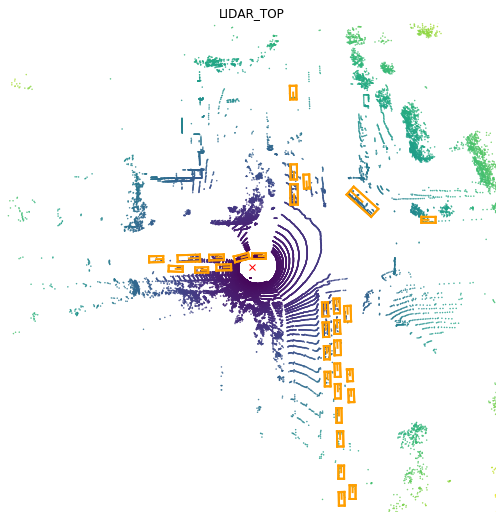

In [10]:
boxes = level5data.get_boxes(sample_lidar_token)

target_im = np.zeros(bev.shape[:3], dtype=np.uint8)

def move_boxes_to_car_space(boxes, ego_pose):
    """
    Move boxes from world space to car space.
    Note: mutates input boxes.
    """
    translation = -np.array(ego_pose['translation'])
    rotation = Quaternion(ego_pose['rotation']).inverse
    
    for box in boxes:
        # Bring box to car space
        box.translate(translation)
        box.rotate(rotation)
        
def scale_boxes(boxes, factor):
    """
    Note: mutates input boxes
    """
    for box in boxes:
        box.wlh = box.wlh * factor

def draw_boxes(im, voxel_size, boxes, classes, z_offset=0.0):
    for box in boxes:
        # We only care about the bottom corners
        corners = box.bottom_corners()
        corners_voxel = car_to_voxel_coords(corners, im.shape, voxel_size, z_offset).transpose(1,0)
        corners_voxel = corners_voxel[:,:2] # Drop z coord

        class_color = classes.index(box.name) + 1
        
        if class_color == 0:
            raise Exception("Unknown class: {}".format(box.name))

        cv2.drawContours(im, np.int0([corners_voxel]), 0, (class_color, class_color, class_color), -1)

move_boxes_to_car_space(boxes, ego_pose)
scale_boxes(boxes, 0.8)
draw_boxes(target_im, voxel_size, boxes, classes, z_offset=z_offset)

#See the result: it is a BEV view.
def visualize_lidar_of_sample(sample_token, axes_limit=80):
    sample = level5data.get("sample", sample_token)
    sample_lidar_token = sample["data"]["LIDAR_TOP"]
    level5data.render_sample_data(sample_lidar_token, axes_limit=axes_limit)
visualize_lidar_of_sample(sample_token)

In [19]:
# Some hyperparameters we'll need to define for the system
voxel_size = (0.4, 0.4, 1.5)
z_offset = -2.0
bev_shape = (336, 336, 3)

# We scale down each box so they are more separated when projected into our coarse voxel space.
box_scale = 0.8

# "bev" stands for birds eye view
train_data_folder = os.path.join(ARTIFACTS_FOLDER, "bev_train_data")
validation_data_folder = os.path.join(ARTIFACTS_FOLDER, "./bev_validation_data")

NUM_WORKERS = os.cpu_count()

def prepare_training_data_for_scene(first_sample_token, output_folder, bev_shape, voxel_size, z_offset, box_scale):
    """
    Given a first sample token (in a scene), output rasterized input volumes and targets in birds-eye-view perspective.
    

    """
    sample_token = first_sample_token
    
    while sample_token:
        
        sample = level5data.get("sample", sample_token)

        sample_lidar_token = sample["data"]["LIDAR_TOP"]
        lidar_data = level5data.get("sample_data", sample_lidar_token)
        lidar_filepath = level5data.get_sample_data_path(sample_lidar_token)

        ego_pose = level5data.get("ego_pose", lidar_data["ego_pose_token"])
        calibrated_sensor = level5data.get("calibrated_sensor", lidar_data["calibrated_sensor_token"])


        global_from_car = transform_matrix(ego_pose['translation'],
                                           Quaternion(ego_pose['rotation']), inverse=False)

        car_from_sensor = transform_matrix(calibrated_sensor['translation'], Quaternion(calibrated_sensor['rotation']),
                                            inverse=False)

        try:
            lidar_pointcloud = LidarPointCloud.from_file(lidar_filepath)
            lidar_pointcloud.transform(car_from_sensor)
        except Exception as e:
            print ("Failed to load Lidar Pointcloud for {}: {}:".format(sample_token, e))
            sample_token = sample["next"]
            continue
        
        bev = create_voxel_pointcloud(lidar_pointcloud.points, bev_shape, voxel_size=voxel_size, z_offset=z_offset)
        bev = normalize_voxel_intensities(bev)

        
        boxes = level5data.get_boxes(sample_lidar_token)

        target = np.zeros_like(bev)

        move_boxes_to_car_space(boxes, ego_pose)
        scale_boxes(boxes, box_scale)
        draw_boxes(target, voxel_size, boxes=boxes, classes=classes, z_offset=z_offset)

        bev_im = np.round(bev*255).astype(np.uint8)
        target_im = target[:,:,0] # take one channel only
        
        semantic_im = get_semantic_map_around_ego(map_mask, ego_pose, voxel_size[0], target_im.shape)
        semantic_im = np.round(semantic_im*255).astype(np.uint8)

        cv2.imwrite(os.path.join(output_folder, "{}_input.png".format(sample_token)), bev_im)
        cv2.imwrite(os.path.join(output_folder, "{}_target.png".format(sample_token)), target_im)
        cv2.imwrite(os.path.join(output_folder, "{}_map.png".format(sample_token)), semantic_im)
        
        sample_token = sample["next"]


In [ ]:
for df, data_folder in [(train_df, train_data_folder), (validation_df, validation_data_folder)]:
    print("Preparing data into {} using {} workers".format(data_folder, NUM_WORKERS))
    first_samples = df.first_sample_token.values
    os.makedirs(data_folder, exist_ok=True)
    process_func = partial(prepare_training_data_for_scene,
                           output_folder=data_folder, bev_shape=bev_shape, voxel_size=voxel_size, z_offset=z_offset, box_scale=box_scale)

    pool = Pool(NUM_WORKERS)
    for _ in tqdm_notebook(pool.imap_unordered(process_func, first_samples), total=len(first_samples)):
        pass
    pool.close()

Preparing data into ./artifacts\bev_train_data using 4 workers


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

class BEVImageDataset(torch.utils.data.Dataset):
    def __init__(self, input_filepaths, target_filepaths, map_filepaths=None):
        self.input_filepaths = input_filepaths
        self.target_filepaths = target_filepaths
        self.map_filepaths = map_filepaths
        
        if map_filepaths is not None:
            assert len(input_filepaths) == len(map_filepaths)
        
        assert len(input_filepaths) == len(target_filepaths)

    def __len__(self):
        return len(self.input_filepaths)

    def __getitem__(self, idx):
        input_filepath = self.input_filepaths[idx]
        target_filepath = self.target_filepaths[idx]
        
        sample_token = input_filepath.split("/")[-1].replace("_input.png","")
        
        im = cv2.imread(input_filepath, cv2.IMREAD_UNCHANGED)
        
        if self.map_filepaths:
            map_filepath = self.map_filepaths[idx]
            map_im = cv2.imread(map_filepath, cv2.IMREAD_UNCHANGED)
            im = np.concatenate((im, map_im), axis=2)
        
        target = cv2.imread(target_filepath, cv2.IMREAD_UNCHANGED)
        
        im = im.astype(np.float32)/255
        target = target.astype(np.int64)
        
        im = torch.from_numpy(im.transpose(2,0,1))
        target = torch.from_numpy(target)
        
        return im, target, sample_token

input_filepaths = sorted(glob.glob(os.path.join(train_data_folder, "*_input.png")))
target_filepaths = sorted(glob.glob(os.path.join(train_data_folder, "*_target.png")))
map_filepaths = sorted(glob.glob(os.path.join(train_data_folder, "*_map.png")))

train_dataset = BEVImageDataset(input_filepaths, target_filepaths, map_filepaths)
im, target, sample_token = train_dataset[0]
im = im.numpy()
target = target.numpy()

plt.figure(figsize=(16,8))

target_as_rgb = np.repeat(target[...,None], 3, 2)
# Transpose the input volume CXY to XYC order, which is what matplotlib requires.
plt.imshow(np.hstack((im.transpose(1,2,0)[...,:3], im.transpose(1,2,0)[...,3:], target_as_rgb)))
plt.title(sample_token)
plt.show()

visualize_lidar_of_sample(sample_token)

IndexError: list index out of range

## <font color="pink">TRAINING</font>
Based on the [AVOD algorithm](https://github.com/kujason/avod), we train the dataset. 
The goal is to study how the accuracy changes based on the type of sensors in input, and their number, thus changes to the AVOD algorithm have been made. Here we keep the two stage model.
Will be divided in steps, to mimick the divisions made by AVOD's authors in the code.

With respect to the original AVOD code, the following changes have been made:
<li> Upgrades for compatibity issues with tensorflow 2.0: migrated from slim libs to keras</li>
<li> Changes to support single type input </li>

<font color="violet">[TODO: maybe working try to convert to lyft, without using lyft in kitti format: useful later]</font>

In [ ]:
import avod
#from avod.builders.dataset_builder import DatasetBuilder
#from avod.core.models.avod_model import AvodModel
#from avod.core.models.rpn_model import RpnModel
from avod.core import trainer

<b>RPN MODEL</b>: It is the fist subnetwork that makes up the double stage AVOD algorithm

In [ ]:
"""Contains modified VGG model definition to extract features from
Bird's eye view input.

Usage:
    outputs, end_points = BevVgg(inputs, layers_config)
"""

from avod.core.feature_extractors import bev_feature_extractor
import tensorflow as tf
#slim = tf.contrib.slim


class BevVgg(bev_feature_extractor.BevFeatureExtractor):

#      def vgg_arg_scope(self, weight_decay=0.0005):
#          """Defines the VGG arg scope.

#          Args:
#            weight_decay: The l2 regularization coefficient.

#          Returns:
#            An arg_scope.
#          """
#          with slim.arg_scope([slim.conv2d, slim.fully_connected],
#                              activation_fn=tf.nn.relu,
#                              weights_regularizer=slim.l2_regularizer(
#                                  weight_decay),
#                              biases_initializer=tf.zeros_initializer()):
#                 with slim.arg_scope([slim.conv2d], padding='SAME') as arg_sc:
#                     return arg_sc

    def build(self,
              inputs,
              input_pixel_size,
              is_training,
              scope='bev_vgg'):
        """ Modified VGG for BEV feature extraction

        Note: All the fully_connected layers have been transformed to conv2d
              layers and are implemented in the main model.

        Args:
            inputs: a tensor of size [batch_size, height, width, channels].
            input_pixel_size: size of the input (H x W)
            is_training: True for training, False fo validation/testing.
            scope: Optional scope for the variables.

        Returns:
            The last op containing the log predictions and end_points dict.
        """
        
        def list_to_dict(lst):
            """Short function to convert the list of the output tensor's collection 
            into an indexed dictionary.
            
            Args: the collection list
            Returns: the dictionary from that list
            
            """
            op = { i : lst[i] for i in range(0, len(lst) ) }
            return op

        #vgg_config = self.config
        weight_decay = 0.0005
#         with slim.arg_scope(self.vgg_arg_scope(
#                 weight_decay=vgg_config.l2_weight_decay)):
        with tf.variable_scope(scope, 'bev_vgg', [inputs]) as sc:
            end_points_collection = sc.name + '_end_points'
                # Collect outputs for conv2d, fully_connected and max_pool2d.
#             with slim.arg_scope([slim.conv2d, slim.max_pool2d],
#                                 outputs_collections=end_points_collection):
            
            net = tf.keras.layers.Conv2D(inputs, filters = 32, stride = [3,3], bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,
                                        kernel_initializer=tf.keras.regularizers.l2(weight_decay), use_bias=False, padding='same')
            tf.add_to_collection("end_points_collection", net)
            net = tf.keras.layers.Conv2D(net, filters = 32, stride = [3,3], bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,
                                        kernel_initializer=tf.keras.regularizers.l2(weight_decay), use_bias=False, padding='same')
            tf.add_to_collection("end_points_collection", net)
            
            net = tf.keras.layers.MaxPooling2D(net, stride=[2,2])
            tf.add_to_collection("end_points_collection", net)
            
            net = tf.keras.layers.Conv2D(net, filters = 64, stride = [3,3], bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,
                                        kernel_initializer=tf.keras.regularizers.l2(weight_decay), use_bias=False, padding='same')
            tf.add_to_collection("end_points_collection", net)
            net = tf.keras.layers.Conv2D(net, filters = 64, stride = [3,3], bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,
                                        kernel_initializer=tf.keras.regularizers.l2(weight_decay), use_bias=False, padding='same')
            tf.add_to_collection("end_points_collection", net)
            
            net = tf.keras.layers.MaxPooling2D(net, stride=[2,2])
            tf.add_to_collection("end_points_collection", net)
            
            net = tf.keras.layers.Conv2D(net, filters = 128, stride = [3,3], bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,
                                        kernel_initializer=tf.keras.regularizers.l2(weight_decay), use_bias=False, padding='same')
            tf.add_to_collection("end_points_collection", net)
            net = tf.keras.layers.Conv2D(net, filters = 128, stride = [3,3], bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,
                                        kernel_initializer=tf.keras.regularizers.l2(weight_decay), use_bias=False, padding='same')
            tf.add_to_collection("end_points_collection", net)
            net = tf.keras.layers.Conv2D(net, filters = 128, stride = [3,3], bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,
                                        kernel_initializer=tf.keras.regularizers.l2(weight_decay), use_bias=False, padding='same')
            tf.add_to_collection("end_points_collection", net)
            
            net = tf.keras.layers.MaxPooling2D(net, stride=[2,2])
            tf.add_to_collection("end_points_collection", net)
            
            net = tf.keras.layers.Conv2D(net, filters = 256, stride = [3,3], bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,
                                        kernel_initializer=tf.keras.regularizers.l2(weight_decay), use_bias=False, padding='same') 
            tf.add_to_collection("end_points_collection", net)
            net = tf.keras.layers.Conv2D(net, filters = 256, stride = [3,3], bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,
                                        kernel_initializer=tf.keras.regularizers.l2(weight_decay), use_bias=False, padding='same')
            tf.add_to_collection("end_points_collection", net)
            net = tf.keras.layers.Conv2D(net, filters = 256, stride = [3,3], bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,
                                        kernel_initializer=tf.keras.regularizers.l2(weight_decay), use_bias=False, padding='same')
            tf.add_to_collection("end_points_collection", net)
 

            with tf.variable_scope('upsampling'):
            # This extractor downsamples the input by a factor
            # of 8 (3 maxpool layers)
                downsampling_factor = 8
                upsampling_multiplier = 2
                downsampled_shape = input_pixel_size / downsampling_factor

                upsampled_shape = downsampled_shape * upsampling_multiplier 

                feature_maps_out = tf.image.resize_bilinear(
                    net, upsampled_shape)

                # Convert end_points_collection into a end_point dict.
                end_points = list_to_dict(tf.get_collection(
                    end_points_collection))

                return feature_maps_out, end_points


# class BevVggClassification(bev_feature_extractor.BevFeatureExtractor):
#     """This is used in vgg unit tests."""

#     def __init__(self):
#         super(BevVggClassification, self).__init__(None)

#     def build(self,
#               inputs,
#               num_classes=1000,
#               is_training=True,
#               dropout_keep_prob=0.5,
#               spatial_squeeze=True,
#               scope='vgg'):
#         """VGG 11-Layers modified version.

#         Note: All the fully_connected layers have been transformed to conv2d
#               layers.

#         Args:
#           inputs: a tensor of size [batch_size, height, width, channels].
#           num_classes: number of predicted classes.
#           is_training: whether or not the model is being trained.
#           dropout_keep_prob: the probability that activations are kept in the
#                              dropout layers during training.
#           spatial_squeeze: whether or not should squeeze the spatial dimensions
#                            of the outputs. Useful to remove unnecessary
#                            dimensions for classification.
#           scope: Optional scope for the variables.


#         Returns:
#           the last op containing the log predictions and end_points dict.
#         """
#         with tf.variable_scope(scope, 'bev_vgg', [inputs]) as sc:
#             end_points_collection = sc.name + '_end_points'
#             # Collect outputs for conv2d and max_pool2d.
            
#             net = tf.keras.layers.Conv2D(net, filters = 64, stride = [3,3], bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,
#                                         kernel_initializer=tf.keras.regularizers.l2(weight_decay), use_bias=False, padding='same')
#             tf.add_to_collection("end_points_collection", net)
            
#             net = tf.keras.layers.MaxPooling2D(net, stride=[2,2])
#             tf.add_to_collection("end_points_collection", net)
            
#             net = tf.keras.layers.Conv2D(net, filters = 128, stride = [3,3], bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,
#                                         kernel_initializer=tf.keras.regularizers.l2(weight_decay), use_bias=False, padding='same')
#             tf.add_to_collection("end_points_collection", net)
            
#             net = tf.keras.layers.MaxPooling2D(net, stride=[2,2])
#             tf.add_to_collection("end_points_collection", net)
            
#             net = tf.keras.layers.Conv2D(net, filters = 256, stride = [3,3], bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,
#                                         kernel_initializer=tf.keras.regularizers.l2(weight_decay), use_bias=False, padding='same') 
#             tf.add_to_collection("end_points_collection", net)
#             net = tf.keras.layers.Conv2D(net, filters = 256, stride = [3,3], bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,
#                                         kernel_initializer=tf.keras.regularizers.l2(weight_decay), use_bias=False, padding='same')
#             tf.add_to_collection("end_points_collection", net)
            
#             net = tf.keras.layers.MaxPooling2D(net, stride=[2,2])
#             tf.add_to_collection("end_points_collection", net)
    
#             net = tf.keras.layers.Conv2D(net, filters = 512, stride = [3,3], bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,
#                                         kernel_initializer=tf.keras.regularizers.l2(weight_decay), use_bias=False, padding='same') 
#             tf.add_to_collection("end_points_collection", net)
#             net = tf.keras.layers.Conv2D(net, filters = 512, stride = [3,3], bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,
#                                         kernel_initializer=tf.keras.regularizers.l2(weight_decay), use_bias=False, padding='same')
#             tf.add_to_collection("end_points_collection", net)
            
#             net = tf.keras.layers.MaxPooling2D(net, stride=[2,2])
#             tf.add_to_collection("end_points_collection", net)
            
#             net = tf.keras.layers.Conv2D(net, filters = 512, stride = [3,3], bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,
#                                         kernel_initializer=tf.keras.regularizers.l2(weight_decay), use_bias=False, padding='same') 
#             tf.add_to_collection("end_points_collection", net)
#             net = tf.keras.layers.Conv2D(net, filters = 512, stride = [3,3], bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,
#                                         kernel_initializer=tf.keras.regularizers.l2(weight_decay), use_bias=False, padding='same')
#             tf.add_to_collection("end_points_collection", net)
            
#             net = tf.keras.layers.MaxPooling2D(net, stride=[2,2])
#             tf.add_to_collection("end_points_collection", net)
            
#             net = tf.keras.layers.Conv2D(net, filters = 4096, stride = [9,9], bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,
#                                         kernel_initializer=tf.keras.regularizers.l2(weight_decay), use_bias=False, padding='valid') 
#             net = tf.keras.layers.Dropout(net, dropout_keep_prob, noise_shape=None, seed=None)
#             net = tf.keras.layers.Conv2D(net, filters = 4096, stride = [9,9], bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,
#                                         kernel_initializer=tf.keras.regularizers.l2(weight_decay), use_bias=False, padding='valid') 
#             net = tf.keras.layers.Dropout(net, dropout_keep_prob, noise_shape=None, seed=None)
#             net = tf.keras.layers.Conv2D(net, filters = num_classes, stride = [1,1], bias_initializer=tf.zeros_initializer(), activation=None,
#                                         kernel_initializer=tf.keras.regularizers.l2(weight_decay), use_bias=False, padding='valid') 

#             # Convert end_points_collection into a end_point dict.
#             end_points = list_to_dict(tf.get_collection(
#                 end_points_collection))
#             if spatial_squeeze:
#                 net = tf.squeeze(net, [1, 2], name='fc8/squeezed')
#                 end_points[sc.name + '/fc8'] = net
#             return net, end_points


In [ ]:
import avod.builders.config_builder_util as config_builder
model_config, train_config, _, dataset_config = config_builder.get_configs_from_pipeline_file("avod/configs/unittest_pipeline.config", is_training=True)

# im numpy array for LiDar data, we convert all of them in tensors, then concatenate them. 3 Lidars in lyft
num_Lidar[]
for i in num_LiDar:
    inputs=tf.convert_to_tensor(im)

#feed the input tensor to the BEV VGG
outputs, end_points = BevVgg(inputs, layers_config)
#print(outputs, end_points)


In [39]:
#from tensorflow.contrib import slim

from avod.builders import feature_extractor_builder
from avod.core import anchor_encoder
from avod.core import anchor_filter
from avod.core import anchor_projector
from avod.core import box_3d_encoder
from avod.core import constants
from avod.core import losses
from avod.core import model
from avod.core import summary_utils
from avod.core.anchor_generators import grid_anchor_3d_generator
from avod.datasets.kitti import kitti_aug


class RpnModel(model.DetectionModel):
    ##############################
    # Keys for Placeholders
    ##############################
    PL_BEV_INPUT = 'bev_input_pl'
    PL_IMG_INPUT = 'img_input_pl'
    PL_ANCHORS = 'anchors_pl'

    PL_BEV_ANCHORS = 'bev_anchors_pl'
    PL_BEV_ANCHORS_NORM = 'bev_anchors_norm_pl'
    PL_IMG_ANCHORS = 'img_anchors_pl'
    PL_IMG_ANCHORS_NORM = 'img_anchors_norm_pl'
    PL_LABEL_ANCHORS = 'label_anchors_pl'
    PL_LABEL_BOXES_3D = 'label_boxes_3d_pl'
    PL_LABEL_CLASSES = 'label_classes_pl'

    PL_ANCHOR_IOUS = 'anchor_ious_pl'
    PL_ANCHOR_OFFSETS = 'anchor_offsets_pl'
    PL_ANCHOR_CLASSES = 'anchor_classes_pl'

    # Sample info, including keys for projection to image space
    # (e.g. camera matrix, image index, etc.)
    PL_CALIB_P2 = 'frame_calib_p2'
    PL_IMG_IDX = 'current_img_idx'
    PL_GROUND_PLANE = 'ground_plane'

    ##############################
    # Keys for Predictions
    ##############################
    PRED_ANCHORS = 'rpn_anchors'

    PRED_MB_OBJECTNESS_GT = 'rpn_mb_objectness_gt'
    PRED_MB_OFFSETS_GT = 'rpn_mb_offsets_gt'

    PRED_MB_MASK = 'rpn_mb_mask'
    PRED_MB_OBJECTNESS = 'rpn_mb_objectness'
    PRED_MB_OFFSETS = 'rpn_mb_offsets'

    PRED_TOP_INDICES = 'rpn_top_indices'
    PRED_TOP_ANCHORS = 'rpn_top_anchors'
    PRED_TOP_OBJECTNESS_SOFTMAX = 'rpn_top_objectness_softmax'

    ##############################
    # Keys for Loss
    ##############################
    LOSS_RPN_OBJECTNESS = 'rpn_objectness_loss'
    LOSS_RPN_REGRESSION = 'rpn_regression_loss'

    def __init__(self, model_config, train_val_test, dataset):
        """
        Args:
            model_config: configuration for the model
            train_val_test: "train", "val", or "test"
            dataset: the dataset that will provide samples and ground truth
        """

        # Sets model configs (_config)
        super(RpnModel, self).__init__(model_config)

        if train_val_test not in ["train", "val", "test"]:
            raise ValueError('Invalid train_val_test value,'
                             'should be one of ["train", "val", "test"]')
        self._train_val_test = train_val_test

        self._is_training = (self._train_val_test == 'train')

        # Input config
        input_config = self._config.input_config
        self._bev_pixel_size = np.asarray([input_config.bev_dims_h,
                                           input_config.bev_dims_w])
        self._bev_depth = input_config.bev_depth

        self._img_pixel_size = np.asarray([input_config.img_dims_h,
                                           input_config.img_dims_w])
        self._img_depth = input_config.img_depth

        # Rpn config
        rpn_config = self._config.rpn_config
        proposal_roi_crop_size = 3 * 2
        self._fusion_method = rpn_config.rpn_fusion_method

        if self._train_val_test in ["train", "val"]:
            self._nms_size = rpn_config.rpn_train_nms_size
        else:
            self._nms_size = rpn_config.rpn_test_nms_size

        self._nms_iou_thresh = rpn_config.rpn_nms_iou_thresh

        # Feature Extractor Nets
        self._bev_feature_extractor = \
            feature_extractor_builder.get_extractor(
                self._config.layers_config.bev_feature_extractor)
        self._img_feature_extractor = \
            feature_extractor_builder.get_extractor(
                self._config.layers_config.img_feature_extractor)

        # Network input placeholders
        self.placeholders = dict()

        # Inputs to network placeholders
        self._placeholder_inputs = dict()

        # Information about the current sample
        self.sample_info = dict()

        # Dataset
        self.dataset = dataset
        self.dataset.train_val_test = self._train_val_test
        self._area_extents = self.dataset.kitti_utils.area_extents
        self._bev_extents = self.dataset.kitti_utils.bev_extents
        self._cluster_sizes, _ = self.dataset.get_cluster_info()
        self._anchor_strides = self.dataset.kitti_utils.anchor_strides
        self._anchor_generator = \
            grid_anchor_3d_generator.GridAnchor3dGenerator()

        self._path_drop_probabilities = self._config.path_drop_probabilities
        self._train_on_all_samples = self._config.train_on_all_samples
        self._eval_all_samples = self._config.eval_all_samples
        # Overwrite the dataset's variable with the config
        self.dataset.train_on_all_samples = self._train_on_all_samples

        if self._train_val_test in ["val", "test"]:
            # Disable path-drop, this should already be disabled inside the
            # evaluator, but just in case.
            self._path_drop_probabilities[0] = 1.0
            self._path_drop_probabilities[1] = 1.0

    def _add_placeholder(self, dtype, shape, name):
        placeholder = tf.placeholder(dtype, shape, name)
        self.placeholders[name] = placeholder
        return placeholder

    def _set_up_input_pls(self):
        """Sets up input placeholders by adding them to self._placeholders.
        Keys are defined as self.PL_*.
        """
        # Combine config data
        bev_dims = np.append(self._bev_pixel_size, self._bev_depth)

        with tf.variable_scope('bev_input'):
            # Placeholder for BEV image input, to be filled in with feed_dict
            bev_input_placeholder = self._add_placeholder(tf.float32, bev_dims,
                                                          self.PL_BEV_INPUT)

            self._bev_input_batches = tf.expand_dims(
                bev_input_placeholder, axis=0)

            self._bev_preprocessed = \
                self._bev_feature_extractor.preprocess_input(
                    self._bev_input_batches, self._bev_pixel_size)

            # Summary Images
            bev_summary_images = tf.split(
                bev_input_placeholder, self._bev_depth, axis=2)
            tf.summary.image("bev_maps", bev_summary_images,
                             max_outputs=self._bev_depth)

        with tf.variable_scope('img_input'):
            # Take variable size input images
            img_input_placeholder = self._add_placeholder(
                tf.float32,
                [None, None, self._img_depth],
                self.PL_IMG_INPUT)

            self._img_input_batches = tf.expand_dims(
                img_input_placeholder, axis=0)

            self._img_preprocessed = \
                self._img_feature_extractor.preprocess_input(
                    self._img_input_batches, self._img_pixel_size)

            # Summary Image
            tf.summary.image("rgb_image", self._img_preprocessed,
                             max_outputs=2)

        with tf.variable_scope('pl_labels'):
            self._add_placeholder(tf.float32, [None, 6],
                                  self.PL_LABEL_ANCHORS)
            self._add_placeholder(tf.float32, [None, 7],
                                  self.PL_LABEL_BOXES_3D)
            self._add_placeholder(tf.float32, [None],
                                  self.PL_LABEL_CLASSES)

        # Placeholders for anchors
        with tf.variable_scope('pl_anchors'):
            self._add_placeholder(tf.float32, [None, 6],
                                  self.PL_ANCHORS)
            self._add_placeholder(tf.float32, [None],
                                  self.PL_ANCHOR_IOUS)
            self._add_placeholder(tf.float32, [None, 6],
                                  self.PL_ANCHOR_OFFSETS)
            self._add_placeholder(tf.float32, [None],
                                  self.PL_ANCHOR_CLASSES)

            with tf.variable_scope('bev_anchor_projections'):
                self._add_placeholder(tf.float32, [None, 4],
                                      self.PL_BEV_ANCHORS)
                self._bev_anchors_norm_pl = self._add_placeholder(
                    tf.float32, [None, 4], self.PL_BEV_ANCHORS_NORM)

            with tf.variable_scope('img_anchor_projections'):
                self._add_placeholder(tf.float32, [None, 4],
                                      self.PL_IMG_ANCHORS)
                self._img_anchors_norm_pl = self._add_placeholder(
                    tf.float32, [None, 4], self.PL_IMG_ANCHORS_NORM)

            with tf.variable_scope('sample_info'):
                # the calib matrix shape is (3 x 4)
                self._add_placeholder(
                    tf.float32, [3, 4], self.PL_CALIB_P2)
                self._add_placeholder(tf.int32,
                                      shape=[1],
                                      name=self.PL_IMG_IDX)
                self._add_placeholder(tf.float32, [4], self.PL_GROUND_PLANE)

    def _set_up_feature_extractors(self):
        """Sets up feature extractors and stores feature maps and
        bottlenecks as member variables.
        """

        self.bev_feature_maps, self.bev_end_points = \
            self._bev_feature_extractor.build(
                self._bev_preprocessed,
                self._bev_pixel_size,
                self._is_training)

        self.img_feature_maps, self.img_end_points = \
            self._img_feature_extractor.build(
                self._img_preprocessed,
                self._img_pixel_size,
                self._is_training)

        with tf.variable_scope('bev_bottleneck'):
            self.bev_bottleneck = slim.conv2d(
                self.bev_feature_maps,
                1, [1, 1],
                scope='bottleneck',
                normalizer_fn=slim.batch_norm,
                normalizer_params={
                    'is_training': self._is_training})

        with tf.variable_scope('img_bottleneck'):
            self.img_bottleneck = slim.conv2d(
                self.img_feature_maps,
                1, [1, 1],
                scope='bottleneck',
                normalizer_fn=slim.batch_norm,
                normalizer_params={
                    'is_training': self._is_training})

        # # Visualize the end point feature maps being used
        # for feature_map in list(self.bev_end_points.items()):
        #     if 'conv' in feature_map[0]:
        #         summary_utils.add_feature_maps_from_dict(self.bev_end_points,
        #                                                  feature_map[0])
        #
        # for feature_map in list(self.img_end_points.items()):
        #     if 'conv' in feature_map[0]:
        #         summary_utils.add_feature_maps_from_dict(self.img_end_points,
        #                                                  feature_map[0])

    def build(self):

        # Setup input placeholders
        self._set_up_input_pls()

        # Setup feature extractors
        self._set_up_feature_extractors()

        bev_proposal_input = self.bev_bottleneck
        img_proposal_input = self.img_bottleneck

        fusion_mean_div_factor = 2.0

        # If both img and bev probabilites are set to 1.0, don't do
        # path drop.
        if not (self._path_drop_probabilities[0] ==
                self._path_drop_probabilities[1] == 1.0):
            with tf.variable_scope('rpn_path_drop'):

                random_values = tf.random_uniform(shape=[3],
                                                  minval=0.0,
                                                  maxval=1.0)

                img_mask, bev_mask = self.create_path_drop_masks(
                    self._path_drop_probabilities[0],
                    self._path_drop_probabilities[1],
                    random_values)

                img_proposal_input = tf.multiply(img_proposal_input,
                                                 img_mask)

                bev_proposal_input = tf.multiply(bev_proposal_input,
                                                 bev_mask)

                self.img_path_drop_mask = img_mask
                self.bev_path_drop_mask = bev_mask

                # Overwrite the division factor
                fusion_mean_div_factor = img_mask + bev_mask

        with tf.variable_scope('proposal_roi_pooling'):

            with tf.variable_scope('box_indices'):
                def get_box_indices(boxes):
                    proposals_shape = boxes.get_shape().as_list()
                    if any(dim is None for dim in proposals_shape):
                        proposals_shape = tf.shape(boxes)
                    ones_mat = tf.ones(proposals_shape[:2], dtype=tf.int32)
                    multiplier = tf.expand_dims(
                        tf.range(start=0, limit=proposals_shape[0]), 1)
                    return tf.reshape(ones_mat * multiplier, [-1])

                bev_boxes_norm_batches = tf.expand_dims(
                    self._bev_anchors_norm_pl, axis=0)

                # These should be all 0's since there is only 1 image
                tf_box_indices = get_box_indices(bev_boxes_norm_batches)

            # Do ROI Pooling on BEV
            bev_proposal_rois = tf.image.crop_and_resize(
                bev_proposal_input,
                self._bev_anchors_norm_pl,
                tf_box_indices,
                proposal_roi_crop_size)
            # Do ROI Pooling on image
            img_proposal_rois = tf.image.crop_and_resize(
                img_proposal_input,
                self._img_anchors_norm_pl,
                tf_box_indices,
                proposal_roi_crop_size)

        with tf.variable_scope('proposal_roi_fusion'):
            rpn_fusion_out = None
            if self._fusion_method == 'mean':
                tf_features_sum = tf.add(bev_proposal_rois, img_proposal_rois)
                rpn_fusion_out = tf.divide(tf_features_sum,
                                           fusion_mean_div_factor)
            elif self._fusion_method == 'concat':
                rpn_fusion_out = tf.concat(
                    [bev_proposal_rois, img_proposal_rois], axis=3)
            else:
                raise ValueError('Invalid fusion method', self._fusion_method)

        # TODO: move this section into an separate AnchorPredictor class
        with tf.variable_scope('anchor_predictor', 'ap', [rpn_fusion_out]):
            tensor_in = rpn_fusion_out

            # Rpn layers config
            l2_weight_decay = 0.005
            weights_regularizer = tf.keras.regularizers.l2(l2_weight_decay)
            #weights_regularizer = slim.l2_regularizer(l2_weight_decay)

            #with slim.arg_scope([slim.conv2d], weights_regularizer=weights_regularizer):
            # Use conv2d instead of fully_connected layers.
            cls_fc6 = tf.keras.layers.Conv2D(tensor_in,
                                    kernel_regularizer=weights_regularizer,           
                                    filters = 32,
                                    kernel_size = proposal_roi_crop_size,
                                    padding='VALID')

            cls_fc6_drop = tf.keras.layers.Dropout(cls_fc6,
                                    rate = 0.5)

            cls_fc7 = tf.keras.layers.Conv2D(cls_fc6_drop,
                                    filters = 32,
                                    stride = [1, 1],
                                    kernel_regularizer = weights_regularizer)

            cls_fc7_drop = tf.keras.layers.Dropout(cls_fc7,
                                    rate = 0.5)

            cls_fc8 = tf.keras.layers.Conv2D(cls_fc7_drop,
                                    kernel_regularizer=weights_regularizer,
                                    filters = 2,
                                    stride = [1, 1])

            objectness = tf.squeeze(cls_fc8, [1, 2],
                                    name='cls_fc8/squeezed')

            # Use conv2d instead of fully_connected layers.
            reg_fc6 = tf.keras.layers.Conv2D(tensor_in,
                                    kernel_regularizer = weights_regularizer,
                                    filters = 32,
                                    kernel_size = proposal_roi_crop_size,
                                    padding='VALID')

            reg_fc6_drop = tf.keras.layers.Dropout(reg_fc6,
                                        rate = 0.5)

            reg_fc7 = tf.keras.layers.Conv2D(reg_fc6_drop,
                                    filters = 32,
                                    stride = [1, 1],
                                    kernel_regularizer = weights_regularizer)

            reg_fc7_drop = tf.keras.layers.Dropout(reg_fc7,
                                        rate = 0.5)

            reg_fc8 = tf.keras.layers.Conv2D(reg_fc7_drop,
                                    filters = 6,
                                    kernel_regularizer=weights_regularizer,
                                    stride = [1, 1])

            offsets = tf.squeeze(reg_fc8, [1, 2],
                                name='reg_fc8/squeezed')

        # Histogram summaries
        with tf.variable_scope('histograms_feature_extractor'):
            with tf.variable_scope('bev_vgg'):
                for end_point in self.bev_end_points:
                    tf.summary.histogram(
                        end_point, self.bev_end_points[end_point])

            with tf.variable_scope('img_vgg'):
                for end_point in self.img_end_points:
                    tf.summary.histogram(
                        end_point, self.img_end_points[end_point])

        with tf.variable_scope('histograms_rpn'):
            with tf.variable_scope('anchor_predictor'):
                fc_layers = [cls_fc6, cls_fc7, cls_fc8, objectness,
                             reg_fc6, reg_fc7, reg_fc8, offsets]
                for fc_layer in fc_layers:
                    # fix the name to avoid tf warnings
                    tf.summary.histogram(fc_layer.name.replace(':', '_'),
                                         fc_layer)

        # Return the proposals
        with tf.variable_scope('proposals'):
            anchors = self.placeholders[self.PL_ANCHORS]

            # Decode anchor regression offsets
            with tf.variable_scope('decoding'):
                regressed_anchors = anchor_encoder.offset_to_anchor(
                        anchors, offsets)

            with tf.variable_scope('bev_projection'):
                _, bev_proposal_boxes_norm = anchor_projector.project_to_bev(
                    regressed_anchors, self._bev_extents)

            with tf.variable_scope('softmax'):
                objectness_softmax = tf.nn.softmax(objectness)

            with tf.variable_scope('nms'):
                objectness_scores = objectness_softmax[:, 1]

                # Do NMS on regressed anchors
                top_indices = tf.image.non_max_suppression(
                    bev_proposal_boxes_norm, objectness_scores,
                    max_output_size=self._nms_size,
                    iou_threshold=self._nms_iou_thresh)

                top_anchors = tf.gather(regressed_anchors, top_indices)
                top_objectness_softmax = tf.gather(objectness_scores,
                                                   top_indices)
                # top_offsets = tf.gather(offsets, top_indices)
                # top_objectness = tf.gather(objectness, top_indices)

        # Get mini batch
        all_ious_gt = self.placeholders[self.PL_ANCHOR_IOUS]
        all_offsets_gt = self.placeholders[self.PL_ANCHOR_OFFSETS]
        all_classes_gt = self.placeholders[self.PL_ANCHOR_CLASSES]

        with tf.variable_scope('mini_batch'):
            mini_batch_utils = self.dataset.kitti_utils.mini_batch_utils
            mini_batch_mask, _ = \
                mini_batch_utils.sample_rpn_mini_batch(all_ious_gt)

        # ROI summary images
        rpn_mini_batch_size = \
            self.dataset.kitti_utils.mini_batch_utils.rpn_mini_batch_size
        with tf.variable_scope('bev_rpn_rois'):
            mb_bev_anchors_norm = tf.boolean_mask(self._bev_anchors_norm_pl,
                                                  mini_batch_mask)
            mb_bev_box_indices = tf.zeros_like(
                tf.boolean_mask(all_classes_gt, mini_batch_mask),
                dtype=tf.int32)

            # Show the ROIs of the BEV input density map
            # for the mini batch anchors
            bev_input_rois = tf.image.crop_and_resize(
                self._bev_preprocessed,
                mb_bev_anchors_norm,
                mb_bev_box_indices,
                (32, 32))

            bev_input_roi_summary_images = tf.split(
                bev_input_rois, self._bev_depth, axis=3)
            tf.summary.image('bev_rpn_rois',
                             bev_input_roi_summary_images[-1],
                             max_outputs=rpn_mini_batch_size)

        with tf.variable_scope('img_rpn_rois'):
            # ROIs on image input
            mb_img_anchors_norm = tf.boolean_mask(self._img_anchors_norm_pl,
                                                  mini_batch_mask)
            mb_img_box_indices = tf.zeros_like(
                tf.boolean_mask(all_classes_gt, mini_batch_mask),
                dtype=tf.int32)

            # Do test ROI pooling on mini batch
            img_input_rois = tf.image.crop_and_resize(
                self._img_preprocessed,
                mb_img_anchors_norm,
                mb_img_box_indices,
                (32, 32))

            tf.summary.image('img_rpn_rois',
                             img_input_rois,
                             max_outputs=rpn_mini_batch_size)

        # Ground Truth Tensors
        with tf.variable_scope('one_hot_classes'):

            # Anchor classification ground truth
            # Object / Not Object
            min_pos_iou = \
                self.dataset.kitti_utils.mini_batch_utils.rpn_pos_iou_range[0]

            objectness_classes_gt = tf.cast(
                tf.greater_equal(all_ious_gt, min_pos_iou),
                dtype=tf.int32)
            objectness_gt = tf.one_hot(
                objectness_classes_gt, depth=2,
                on_value=1.0 - self._config.label_smoothing_epsilon,
                off_value=self._config.label_smoothing_epsilon)

        # Mask predictions for mini batch
        with tf.variable_scope('prediction_mini_batch'):
            objectness_masked = tf.boolean_mask(objectness, mini_batch_mask)
            offsets_masked = tf.boolean_mask(offsets, mini_batch_mask)

        with tf.variable_scope('ground_truth_mini_batch'):
            objectness_gt_masked = tf.boolean_mask(
                objectness_gt, mini_batch_mask)
            offsets_gt_masked = tf.boolean_mask(all_offsets_gt,
                                                mini_batch_mask)

        # Specify the tensors to evaluate
        predictions = dict()

        # Temporary predictions for debugging
        # predictions['anchor_ious'] = anchor_ious
        # predictions['anchor_offsets'] = all_offsets_gt

        if self._train_val_test in ['train', 'val']:
            # All anchors
            predictions[self.PRED_ANCHORS] = anchors

            # Mini-batch masks
            predictions[self.PRED_MB_MASK] = mini_batch_mask
            # Mini-batch predictions
            predictions[self.PRED_MB_OBJECTNESS] = objectness_masked
            predictions[self.PRED_MB_OFFSETS] = offsets_masked

            # Mini batch ground truth
            predictions[self.PRED_MB_OFFSETS_GT] = offsets_gt_masked
            predictions[self.PRED_MB_OBJECTNESS_GT] = objectness_gt_masked

            # Proposals after nms
            predictions[self.PRED_TOP_INDICES] = top_indices
            predictions[self.PRED_TOP_ANCHORS] = top_anchors
            predictions[
                self.PRED_TOP_OBJECTNESS_SOFTMAX] = top_objectness_softmax

        else:
            # self._train_val_test == 'test'
            predictions[self.PRED_TOP_ANCHORS] = top_anchors
            predictions[
                self.PRED_TOP_OBJECTNESS_SOFTMAX] = top_objectness_softmax

        return predictions

    def create_feed_dict(self, sample_index=None):
        """ Fills in the placeholders with the actual input values.
            Currently, only a batch size of 1 is supported

        Args:
            sample_index: optional, only used when train_val_test == 'test',
                a particular sample index in the dataset
                sample list to build the feed_dict for

        Returns:
            a feed_dict dictionary that can be used in a tensorflow session
        """

        if self._train_val_test in ["train", "val"]:

            # sample_index should be None
            if sample_index is not None:
                raise ValueError('sample_index should be None. Do not load '
                                 'particular samples during train or val')

            # During training/validation, we need a valid sample
            # with anchor info for loss calculation
            sample = None
            anchors_info = []

            valid_sample = False
            while not valid_sample:
                if self._train_val_test == "train":
                    # Get the a random sample from the remaining epoch
                    samples = self.dataset.next_batch(batch_size=1)

                else:  # self._train_val_test == "val"
                    # Load samples in order for validation
                    samples = self.dataset.next_batch(batch_size=1,
                                                      shuffle=False)

                # Only handle one sample at a time for now
                sample = samples[0]
                anchors_info = sample.get(constants.KEY_ANCHORS_INFO)

                # When training, if the mini batch is empty, go to the next
                # sample. Otherwise carry on with found the valid sample.
                # For validation, even if 'anchors_info' is empty, keep the
                # sample (this will help penalize false positives.)
                # We will substitue the necessary info with zeros later on.
                # Note: Training/validating all samples can be switched off.
                train_cond = (self._train_val_test == "train" and
                              self._train_on_all_samples)
                eval_cond = (self._train_val_test == "val" and
                             self._eval_all_samples)
                if anchors_info or train_cond or eval_cond:
                    valid_sample = True
        else:
            # For testing, any sample should work
            if sample_index is not None:
                samples = self.dataset.load_samples([sample_index])
            else:
                samples = self.dataset.next_batch(batch_size=1, shuffle=False)

            # Only handle one sample at a time for now
            sample = samples[0]
            anchors_info = sample.get(constants.KEY_ANCHORS_INFO)

        sample_name = sample.get(constants.KEY_SAMPLE_NAME)
        sample_augs = sample.get(constants.KEY_SAMPLE_AUGS)

        # Get ground truth data
        label_anchors = sample.get(constants.KEY_LABEL_ANCHORS)
        label_classes = sample.get(constants.KEY_LABEL_CLASSES)
        # We only need orientation from box_3d
        label_boxes_3d = sample.get(constants.KEY_LABEL_BOXES_3D)

        # Network input data
        image_input = sample.get(constants.KEY_IMAGE_INPUT)
        bev_input = sample.get(constants.KEY_BEV_INPUT)

        # Image shape (h, w)
        image_shape = [image_input.shape[0], image_input.shape[1]]

        ground_plane = sample.get(constants.KEY_GROUND_PLANE)
        stereo_calib_p2 = sample.get(constants.KEY_STEREO_CALIB_P2)

        # Fill the placeholders for anchor information
        self._fill_anchor_pl_inputs(anchors_info=anchors_info,
                                    ground_plane=ground_plane,
                                    image_shape=image_shape,
                                    stereo_calib_p2=stereo_calib_p2,
                                    sample_name=sample_name,
                                    sample_augs=sample_augs)

        # this is a list to match the explicit shape for the placeholder
        self._placeholder_inputs[self.PL_IMG_IDX] = [int(sample_name)]

        # Fill in the rest
        self._placeholder_inputs[self.PL_BEV_INPUT] = bev_input
        self._placeholder_inputs[self.PL_IMG_INPUT] = image_input

        self._placeholder_inputs[self.PL_LABEL_ANCHORS] = label_anchors
        self._placeholder_inputs[self.PL_LABEL_BOXES_3D] = label_boxes_3d
        self._placeholder_inputs[self.PL_LABEL_CLASSES] = label_classes

        # Sample Info
        # img_idx is a list to match the placeholder shape
        self._placeholder_inputs[self.PL_IMG_IDX] = [int(sample_name)]
        self._placeholder_inputs[self.PL_CALIB_P2] = stereo_calib_p2
        self._placeholder_inputs[self.PL_GROUND_PLANE] = ground_plane

        # Temporary sample info for debugging
        self.sample_info.clear()
        self.sample_info['sample_name'] = sample_name
        self.sample_info['rpn_mini_batch'] = anchors_info

        # Create a feed_dict and fill it with input values
        feed_dict = dict()
        for key, value in self.placeholders.items():
            feed_dict[value] = self._placeholder_inputs[key]

        return feed_dict

    def _fill_anchor_pl_inputs(self,
                               anchors_info,
                               ground_plane,
                               image_shape,
                               stereo_calib_p2,
                               sample_name,
                               sample_augs):
        """
        Fills anchor placeholder inputs with corresponding data

        Args:
            anchors_info: anchor info from mini_batch_utils
            ground_plane: ground plane coefficients
            image_shape: image shape (h, w), used for projecting anchors
            sample_name: name of the sample, e.g. "000001"
            sample_augs: list of sample augmentations
        """

        # Lists for merging anchors info
        all_anchor_boxes_3d = []
        anchors_ious = []
        anchor_offsets = []
        anchor_classes = []

        # Create anchors for each class
        if len(self.dataset.classes) > 1:
            for class_idx in range(len(self.dataset.classes)):
                # Generate anchors for all classes
                grid_anchor_boxes_3d = self._anchor_generator.generate(
                    area_3d=self._area_extents,
                    anchor_3d_sizes=self._cluster_sizes[class_idx],
                    anchor_stride=self._anchor_strides[class_idx],
                    ground_plane=ground_plane)
                all_anchor_boxes_3d.append(grid_anchor_boxes_3d)
            all_anchor_boxes_3d = np.concatenate(all_anchor_boxes_3d)
        else:
            # Don't loop for a single class
            class_idx = 0
            grid_anchor_boxes_3d = self._anchor_generator.generate(
                area_3d=self._area_extents,
                anchor_3d_sizes=self._cluster_sizes[class_idx],
                anchor_stride=self._anchor_strides[class_idx],
                ground_plane=ground_plane)
            all_anchor_boxes_3d = grid_anchor_boxes_3d

        # Filter empty anchors
        # Skip if anchors_info is []
        sample_has_labels = True
        if self._train_val_test in ['train', 'val']:
            # Read in anchor info during training / validation
            if anchors_info:
                anchor_indices, anchors_ious, anchor_offsets, \
                    anchor_classes = anchors_info

                anchor_boxes_3d_to_use = all_anchor_boxes_3d[anchor_indices]
            else:
                train_cond = (self._train_val_test == "train" and
                              self._train_on_all_samples)
                eval_cond = (self._train_val_test == "val" and
                             self._eval_all_samples)
                if train_cond or eval_cond:
                    sample_has_labels = False
        else:
            sample_has_labels = False

        if not sample_has_labels:
            # During testing, or validation with no anchor info, manually
            # filter empty anchors
            # TODO: share voxel_grid_2d with BEV generation if possible
            voxel_grid_2d = \
                self.dataset.kitti_utils.create_sliced_voxel_grid_2d(
                    sample_name, self.dataset.bev_source,
                    image_shape=image_shape)

            # Convert to anchors and filter
            anchors_to_use = box_3d_encoder.box_3d_to_anchor(
                all_anchor_boxes_3d)
            empty_filter = anchor_filter.get_empty_anchor_filter_2d(
                anchors_to_use, voxel_grid_2d, density_threshold=1)

            anchor_boxes_3d_to_use = all_anchor_boxes_3d[empty_filter]

        # Convert lists to ndarrays
        anchor_boxes_3d_to_use = np.asarray(anchor_boxes_3d_to_use)
        anchors_ious = np.asarray(anchors_ious)
        anchor_offsets = np.asarray(anchor_offsets)
        anchor_classes = np.asarray(anchor_classes)

        # Flip anchors and centroid x offsets for augmented samples
        if kitti_aug.AUG_FLIPPING in sample_augs:
            anchor_boxes_3d_to_use = kitti_aug.flip_boxes_3d(
                anchor_boxes_3d_to_use, flip_ry=False)
            if anchors_info:
                anchor_offsets[:, 0] = -anchor_offsets[:, 0]

        # Convert to anchors
        anchors_to_use = box_3d_encoder.box_3d_to_anchor(
            anchor_boxes_3d_to_use)
        num_anchors = len(anchors_to_use)

        # Project anchors into bev
        bev_anchors, bev_anchors_norm = anchor_projector.project_to_bev(
            anchors_to_use, self._bev_extents)

        # Project box_3d anchors into image space
        img_anchors, img_anchors_norm = \
            anchor_projector.project_to_image_space(
                anchors_to_use, stereo_calib_p2, image_shape)

        # Reorder into [y1, x1, y2, x2] for tf.crop_and_resize op
        self._bev_anchors_norm = bev_anchors_norm[:, [1, 0, 3, 2]]
        self._img_anchors_norm = img_anchors_norm[:, [1, 0, 3, 2]]

        # Fill in placeholder inputs
        self._placeholder_inputs[self.PL_ANCHORS] = anchors_to_use

        # If we are in train/validation mode, and the anchor infos
        # are not empty, store them. Checking for just anchors_ious
        # to be non-empty should be enough.
        if self._train_val_test in ['train', 'val'] and \
                len(anchors_ious) > 0:
            self._placeholder_inputs[self.PL_ANCHOR_IOUS] = anchors_ious
            self._placeholder_inputs[self.PL_ANCHOR_OFFSETS] = anchor_offsets
            self._placeholder_inputs[self.PL_ANCHOR_CLASSES] = anchor_classes

        # During test, or val when there is no anchor info
        elif self._train_val_test in ['test'] or \
                len(anchors_ious) == 0:
            # During testing, or validation with no gt, fill these in with 0s
            self._placeholder_inputs[self.PL_ANCHOR_IOUS] = \
                np.zeros(num_anchors)
            self._placeholder_inputs[self.PL_ANCHOR_OFFSETS] = \
                np.zeros([num_anchors, 6])
            self._placeholder_inputs[self.PL_ANCHOR_CLASSES] = \
                np.zeros(num_anchors)
        else:
            raise ValueError('Got run mode {}, and non-empty anchor info'.
                             format(self._train_val_test))

        self._placeholder_inputs[self.PL_BEV_ANCHORS] = bev_anchors
        self._placeholder_inputs[self.PL_BEV_ANCHORS_NORM] = \
            self._bev_anchors_norm
        self._placeholder_inputs[self.PL_IMG_ANCHORS] = img_anchors
        self._placeholder_inputs[self.PL_IMG_ANCHORS_NORM] = \
            self._img_anchors_norm

    def loss(self, prediction_dict):

        # these should include mini-batch values only
        objectness_gt = prediction_dict[self.PRED_MB_OBJECTNESS_GT]
        offsets_gt = prediction_dict[self.PRED_MB_OFFSETS_GT]

        # Predictions
        with tf.variable_scope('rpn_prediction_mini_batch'):
            objectness = prediction_dict[self.PRED_MB_OBJECTNESS]
            offsets = prediction_dict[self.PRED_MB_OFFSETS]

        with tf.variable_scope('rpn_losses'):
            with tf.variable_scope('objectness'):
                cls_loss = losses.WeightedSoftmaxLoss()
                cls_loss_weight = self._config.loss_config.cls_loss_weight
                objectness_loss = cls_loss(objectness,
                                           objectness_gt,
                                           weight=cls_loss_weight)

                with tf.variable_scope('obj_norm'):
                    # normalize by the number of anchor mini-batches
                    objectness_loss = objectness_loss / tf.cast(
                        tf.shape(objectness_gt)[0], dtype=tf.float32)
                    tf.summary.scalar('objectness', objectness_loss)

            with tf.variable_scope('regression'):
                reg_loss = losses.WeightedSmoothL1Loss()
                reg_loss_weight = self._config.loss_config.reg_loss_weight
                anchorwise_localization_loss = reg_loss(offsets,
                                                        offsets_gt,
                                                        weight=reg_loss_weight)
                masked_localization_loss = \
                    anchorwise_localization_loss * objectness_gt[:, 1]
                localization_loss = tf.reduce_sum(masked_localization_loss)

                with tf.variable_scope('reg_norm'):
                    # normalize by the number of positive objects
                    num_positives = tf.reduce_sum(objectness_gt[:, 1])
                    # Assert the condition `num_positives > 0`
                    with tf.control_dependencies(
                            [tf.assert_positive(num_positives)]):
                        localization_loss = localization_loss / num_positives
                        tf.summary.scalar('regression', localization_loss)

            with tf.variable_scope('total_loss'):
                total_loss = objectness_loss + localization_loss

        loss_dict = {
            self.LOSS_RPN_OBJECTNESS: objectness_loss,
            self.LOSS_RPN_REGRESSION: localization_loss,
        }

        return loss_dict, total_loss

    def create_path_drop_masks(self,
                               p_img,
                               p_bev,
                               random_values):
        """Determines global path drop decision based on given probabilities.

        Args:
            p_img: A tensor of float32, probability of keeping image branch
            p_bev: A tensor of float32, probability of keeping bev branch
            random_values: A tensor of float32 of shape [3], the results
                of coin flips, values should range from 0.0 - 1.0.

        Returns:
            final_img_mask: A constant tensor mask containing either one or zero
                depending on the final coin flip probability.
            final_bev_mask: A constant tensor mask containing either one or zero
                depending on the final coin flip probability.
        """

        def keep_branch(): return tf.constant(1.0)

        def kill_branch(): return tf.constant(0.0)

        # The logic works as follows:
        # We have flipped 3 coins, first determines the chance of keeping
        # the image branch, second determines keeping bev branch, the third
        # makes the final decision in the case where both branches were killed
        # off, otherwise the initial img and bev chances are kept.

        img_chances = tf.case([(tf.less(random_values[0], p_img),
                                keep_branch)], default=kill_branch)

        bev_chances = tf.case([(tf.less(random_values[1], p_bev),
                                keep_branch)], default=kill_branch)

        # Decision to determine whether both branches were killed off
        third_flip = tf.logical_or(tf.cast(img_chances, dtype=tf.bool),
                                   tf.cast(bev_chances, dtype=tf.bool))
        third_flip = tf.cast(third_flip, dtype=tf.float32)

        # Make a second choice, for the third case
        # Here we use a 50/50 chance to keep either image or bev
        # If its greater than 0.5, keep the image
        img_second_flip = tf.case([(tf.greater(random_values[2], 0.5),
                                    keep_branch)],
                                  default=kill_branch)
        # If its less than or equal to 0.5, keep bev
        bev_second_flip = tf.case([(tf.less_equal(random_values[2], 0.5),
                                    keep_branch)],
                                  default=kill_branch)

        # Use lambda since this returns another condition and it needs to
        # be callable
        final_img_mask = tf.case([(tf.equal(third_flip, 1),
                                   lambda: img_chances)],
                                 default=lambda: img_second_flip)

        final_bev_mask = tf.case([(tf.equal(third_flip, 1),
                                   lambda: bev_chances)],
                                 default=lambda: bev_second_flip)

        return final_img_mask, final_bev_mask


IndentationError: unexpected indent (bev_vgg.py, line 62)

In [19]:
import tensorflow as tf
